# Transform

In [ ]:
#| default_exp transform
%load_ext autoreload
%autoreload 2

### Overview
This final module handles the actual **graph transformation**, which our library aims to achieve. It contains general auxiliary functions for performing different operations on some graph - adding nodes, cloning them, removing edge attributes, etc.

It also contains **```rewrite```**, the library's main function and the only one the user is supposed to use. ```rewrite``` allows pattern matching in an input graph, graph transformations based on transform rules (as defined in the "rules" module), imperative side-effects based on the matches and much more. It does so by using all the abilities presented in the previous modules and wrapping it all with a simple-to-use interface of a single function.

### Requirements

In [ ]:
#| export
from typing import *
from networkx import DiGraph
from copy import deepcopy

from graph_rewrite.core import NodeName, EdgeName, _create_graph, _plot_graph, _graphs_equal, GraphRewriteException
from graph_rewrite.lhs import lhs_to_graph
from graph_rewrite.match_class import Match, mapping_to_match
from graph_rewrite.matcher import find_matches, FilterFunc
from graph_rewrite.p_rhs_parse import RenderFunc, p_to_graph, rhs_to_graph
from graph_rewrite.rules import Rule, MergePolicy

### Transformation Utilities
The following functions perform different operations on NetworkX graphs - any graph. We will use them when we'll do graph transformations, which perform a subset of these operations on some input graph, based on a predefined rule.

In [ ]:
#| export
_exception_msgs = {
    "no_such_node": lambda node: f"Node {node} does not exist in the input graph.",
    "no_such_edge": lambda edge: f"Edge {edge} does not exist in the input graph.",
    "no_such_attr_in_node": lambda attr, node: f"Attribute {attr} does not exist in input graph's node {node}.",
    "no_such_attr_in_edge": lambda attr, edge: f"Attribute {attr} does not exist in input graph's edge {edge}.",
    "edge_exists": lambda edge: f"Edge {edge} already exists in the input graph.",
    "not_enough_to_merge": lambda: f"Tried to merge less than one nodes."
}

In [ ]:
#| export
def _generate_new_node_name(graph: DiGraph, base_name: NodeName) -> NodeName:
    """Generate a name for a new node, which is unique in the graph to which the node is added,
    based on an initial name suggestion.
    If that suggested name does not exist in the graph, it is used for the new node.
    Otherwise, the new node's name will have the suggested name as a prefix, followed by a serial number (<name>_<num>)
    that makes sure that the name is unique but not too long.

    Args:
        graph (DiGraph): A graph to which the new node is added
        base_name (NodeName): The initial suggestion for the new node's desired name

    Returns:
        NodeName: The name chosen for the new node
    """
    new_name = base_name
    i = 0
    while new_name in graph.nodes():
        i += 1
        new_name = f"{base_name}_{i}"
    return new_name

In [ ]:
#| export
def _clone_node(graph: DiGraph, node_to_clone: NodeName) -> NodeName:
    """Clones a node in the graph. That is, create a new node, whose name denotes its connection to the original node,
    whose edges are copies of the edges connected to the original node, and whose attributes are duplicated
    from the original node.

    Args:
        graph (DiGraph): A graph
        node_to_clone (NodeName): A node in the graph to be cloned

    Raises:
        GraphRewriteException: If the node which should be cloned does not exist in the graph

    Returns:
        NodeName: The name of the new cloned node
    """
    if node_to_clone not in graph.nodes:
        raise GraphRewriteException(_exception_msgs["no_such_node"](node_to_clone))

    # Create a new node name
    clone_name = _generate_new_node_name(graph, node_to_clone)

    # Add this new node to graph
    cloned_node_attrs = graph.nodes(data=True)[node_to_clone]
    graph.add_node(clone_name, **cloned_node_attrs)

    # Clone edges (connect the clone to all original edge endpoints + copy attrs)
    for n, _ in graph.in_edges(node_to_clone):
        if (n, clone_name) not in graph.edges():
            cloned_edge_attrs = graph.edges[n, node_to_clone]
            graph.add_edge(n, clone_name, **cloned_edge_attrs)
    
    for _, n in graph.out_edges(node_to_clone):
        if (clone_name, n) not in graph.edges():
            cloned_edge_attrs = graph.edges[node_to_clone, n]
            graph.add_edge(clone_name, n, **cloned_edge_attrs)
 
    return clone_name

In [ ]:
#| export
def _remove_node(graph: DiGraph, node_to_remove: NodeName):
    """Remove a node from the graph.

    Args:
        graph (DiGraph): A graph
        node_to_remove (NodeName): A node to remove from the graph

    Raises:
        GraphRewriteException: If the removed node doesn't exist in the graph
    """
    if node_to_remove not in graph.nodes():
        raise GraphRewriteException(_exception_msgs["no_such_node"](node_to_remove))
    graph.remove_node(node_to_remove)

In [ ]:
#| export
def _remove_edge(graph: DiGraph, edge_to_remove: EdgeName):
    """Remove an edge from the graph.

    Args:
        graph (DiGraph): A graph
        edge_to_remove (EdgeName): An edge to remove from the graph

    Raises:
        GraphRewriteException: If the removed edge doesn't exist in the graph
    """
    if edge_to_remove not in graph.edges():
        raise GraphRewriteException(_exception_msgs["no_such_edge"](edge_to_remove))
    graph.remove_edge(*edge_to_remove)

In [ ]:
#| export
def _remove_node_attrs(graph: DiGraph, node: NodeName, attrs_to_remove: set):
    """Remove a subset of some node's attributes from the node.

    Args:
        graph (DiGraph): A graph
        node (NodeName): A node in the graph
        attrs_to_remove (set): Attributes of that node to remove

    Raises:
        GraphRewriteException: If the node doesn't exist in the graph, or some of the removed attrs don't exist in the node
    """
    if node not in graph.nodes():
        raise GraphRewriteException(_exception_msgs["no_such_node"](node))
    for attr in attrs_to_remove:
        if attr not in graph.nodes[node]:
            raise GraphRewriteException(_exception_msgs["no_such_attr_in_node"](attr, node))
        del graph.nodes[node][attr]

In [ ]:
#| export
def _remove_edge_attrs(graph: DiGraph, edge: EdgeName, attrs_to_remove: set):
    """Remove a subset of some edge's attributes from the node.

    Args:
        graph (DiGraph): A graph
        edge (EdgeName): An edge in the graph
        attrs_to_remove (set): Attributes of that edge to remove

    Raises:
        GraphRewriteException: If the edge doesn't exist in the graph, or some of the removed attrs don't exist in the edge
    """

    if edge not in graph.edges():
        raise GraphRewriteException(_exception_msgs["no_such_edge"](edge))
    for attr in attrs_to_remove:
        if attr not in graph.edges[edge]:
            raise GraphRewriteException(_exception_msgs["no_such_attr_in_edge"](attr, edge))
        del graph.edges[edge][attr]

In [ ]:
#| export
def _setup_merged_node(graph: DiGraph, nodes_to_merge: set[NodeName], merge_policy: MergePolicy):
    """A helper function for node merging. It calculates all the parameters needed for creating the merged node,
    such as its name, its attributes, the connected edges and their attributes, etc., and returns them all.
    In addition, it removes the original nodes (which are about to be merged) from the graph.

    Args:
        graph (DiGraph): A graph
        nodes_to_merge (set[NodeName]): A set of nodes in the graph to merge
        merge_policy (MergePolicy): A policy that dictates how to merge conflicting attributes

    Returns:
        All the parameters needed for creating the merged node, in this order:
        - The name of the merged node
        - The attrs of the merged node
        - The nodes that are sources of new edges to the merged node
        - The nodes that are targets of new edges from the merged node
        - The attrs of the new edges to the merged node
        - The attrs of the new edges from the merged node
        - A boolean value for whether the new merged node has a self loop (a special case)
        - The attributes of the selp loop, in case such edge exists
    """
    merged_node_name = _generate_new_node_name(graph, "&".join(nodes_to_merge))
    
    merged_node_attrs = {}
    merged_src_nodes, merged_target_nodes = set(), set()
    merged_src_attrs, merged_target_attrs = {}, {} # map a src/target node to the edge's merged attrs
    self_loop, self_loop_attrs = False, {}
    
    for node_to_merge in nodes_to_merge:
        merged_node_attrs = merge_policy(merged_node_attrs, graph.nodes[node_to_merge])
        
        in_edges, out_edges = graph.in_edges(node_to_merge), graph.out_edges(node_to_merge)
        merged_src_nodes.update({s if s not in nodes_to_merge else merged_node_name for s, _ in in_edges})
        merged_target_nodes.update({t if t not in nodes_to_merge else merged_node_name for _, t in out_edges})

        for edge in in_edges:
            edge_attrs, src = graph.edges[edge], edge[0]
            # Add to source attributes
            if src not in merged_src_attrs.keys():
                merged_src_attrs[src] = edge_attrs
            else:
                merged_src_attrs[src] = merge_policy(merged_src_attrs[src], edge_attrs)

            # Handle selp loop
            if src in nodes_to_merge:
                self_loop = True
                self_loop_attrs = merge_policy(self_loop_attrs, edge_attrs)
            
        for edge in out_edges:
            edge_attrs, target = graph.edges[edge], edge[1]
            # Add to source attributes
            if target not in merged_target_attrs.keys():
                merged_target_attrs[target] = edge_attrs
            else:
                merged_target_attrs[target] = merge_policy(merged_target_attrs[target], edge_attrs)

            # Handle selp loop
            if target in nodes_to_merge:
                self_loop = True
                self_loop_attrs = merge_policy(self_loop_attrs, edge_attrs)

        graph.remove_node(node_to_merge)

    return merged_node_name, merged_node_attrs, merged_src_nodes, merged_target_nodes,\
            merged_src_attrs, merged_target_attrs, self_loop, self_loop_attrs

In [ ]:
#| export
def _merge_nodes(graph: DiGraph, nodes_to_merge: set[NodeName], merge_policy: MergePolicy) -> NodeName:
    """Merge a set of nodes in the graph. That is, remove all these nodes are replace them with a new node,
    whose attributes merge the attributes of the original nodes, whose connected edges merge the edges connected to
    the original node, and whose name denotes the nodes which it merges.

    Args:
        graph (DiGraph): A graph
        nodes_to_merge (set[NodeName]): A set of nodes to merge
        merge_policy (MergePolicy): A policy that dictates how to merge conflicting attributes

    Raises:
        GraphRewriteException: If the set of nodes to merge is too small (less than two nodes), or if one of them doesn't
        exist in the graph.

    Returns:
        NodeName: The name of the new merged node
    """
    if len(nodes_to_merge) < 1:
        raise GraphRewriteException(_exception_msgs["not_enough_to_merge"]())
    elif len(nodes_to_merge) == 1:
        return list(nodes_to_merge)[0]
    for node_to_merge in nodes_to_merge:
        if node_to_merge not in graph.nodes:
            raise GraphRewriteException(_exception_msgs["no_such_node"](node_to_merge))

    merged_node_name, merged_node_attrs, merged_src_nodes, merged_target_nodes, \
        merged_src_attrs, merged_target_attrs, self_loop, self_loop_attrs = _setup_merged_node(graph, node_to_merge, merge_policy)

    # Add merged node to graph
    graph.add_node(merged_node_name, **merged_node_attrs)

    # Add merged source and target edges (including a new self loop)
    if self_loop:
        graph.add_edge(merged_node_name, merged_node_name, **self_loop_attrs)
    for src_node in merged_src_nodes:
        if (src_node, merged_node_name) not in graph.edges():
            graph.add_edge(src_node, merged_node_name)
    for target_node in merged_target_nodes:
        if (merged_node_name, target_node) not in graph.edges():
            graph.add_edge(merged_node_name, target_node)
    
    # Add edge attributes (other than selp loop)
    for src_node, attrs in merged_src_attrs.items():
        if src_node not in nodes_to_merge:
            graph.update(edges=[(src_node, merged_node_name, attrs)])
    for target_node, attrs in merged_target_attrs.items():
        if target_node not in nodes_to_merge:
            graph.update(edges=[(merged_node_name, target_node, attrs)])

    return merged_node_name

In [ ]:
#| export
def _add_node(graph: DiGraph, node_to_add: NodeName) -> NodeName:
    """Add a new node to the graph.

    Args:
        graph (DiGraph): A graph
        node_to_add (NodeName): The desired name of the new node

    Returns:
        NodeName: The name of the new added node (based on the name suggested)
    """
    # Create a new node name
    new_name = _generate_new_node_name(graph, node_to_add)
    graph.add_node(new_name)
    return new_name

In [ ]:
#| export
def _add_edge(graph: DiGraph, edge_to_add: EdgeName):
    """Add an edge to the graph.

    Args:
        graph (DiGraph): A graph
        edge_to_add (EdgeName): The edge to add.

    Raises:
        GraphRewriteException: If one of the edge's endpoints doesn't exist in the graph, or the edge itself already exists.
    """
    src, target = edge_to_add
    if src not in graph.nodes():
        raise GraphRewriteException(_exception_msgs["no_such_node"](src))
    elif target not in graph.nodes():
        raise GraphRewriteException(_exception_msgs["no_such_node"](target))
    elif edge_to_add in graph.edges():
        raise GraphRewriteException(_exception_msgs["edge_exists"](edge_to_add))
    else:
        graph.add_edge(src, target)

In [ ]:
#| export
def _add_node_attrs(graph: DiGraph, node: NodeName, attrs_to_add: dict):
    """Add attributes to a node in the graph.

    Args:
        graph (DiGraph): A graph
        node (NodeName): A node in the graph
        attrs_to_add (dict): Attributes to add to the node

    Raises:
        GraphRewriteException: If the node doesn't exist in the graph
    """
    if node not in graph.nodes():
        raise GraphRewriteException(_exception_msgs["no_such_node"](node))
    for attr, val in attrs_to_add.items():
        graph.nodes[node][attr] = val

In [ ]:
#| export
def _add_edge_attrs(graph: DiGraph, edge: EdgeName, attrs_to_add: dict):
    """Add attributes to an edge in the graph.

    Args:
        graph (DiGraph): A graph
        edge (EdgeName): An edge in the graph
        attrs_to_add (dict): Attributes to add to the edge

    Raises:
        GraphRewriteException: If the edge doesn't exist in the graph
    """
    if edge not in graph.edges():
        raise GraphRewriteException(_exception_msgs["no_such_edge"](edge))
    for attr, val in attrs_to_add.items():
        graph.edges[edge][attr] = val

### Rewrite Match
A match rewriting is split into two stages - restrictive and expansive. We'll implemenet them seperately, and then combine them into a single function the transforms an input graph based on a single match.

In [ ]:
#| export
_GREEN = '\033[92m'
_RED = '\033[91m'
_BLACK = '\033[0m'

def _log(msg: str, is_log: bool, color: str = _BLACK):
    """Logging some message to the console.

    Args:
        msg (str): A message to log
        is_log (bool): If True, the log is printed (otherwise, it isn't).
        color (str, optional): A color for the printed message. Defaults to _BLACK.
    """
    if is_log:
        print(f"{color}{msg}{_BLACK}")

In [ ]:
#| export
def _rewrite_match_restrictive(input_graph: DiGraph, rule: Rule, lhs_input_map: dict[NodeName, NodeName], is_log: bool) -> dict[NodeName, NodeName]:
    """Performs the restrictive phase of the rewriting process on some match: Clone nodes, Remove nodes and edges (and/or their attributes).

    Args:
        input_graph (DiGraph): A graph to rewrite
        rule (Rule): A rule that dictates what transformations should the graph go through
        lhs_input_map (dict[NodeName, NodeName]): Maps names of LHS nodes to names of input graph nodes, based on the match which we rewrite
        is_log (bool): If True, logs are printed throughout the process.

    Returns:
        dict[NodeName, NodeName]: maps names of P nodes to names of input graph nodes
    """

    # Initialize an empty mapping from P nodes to input_graph nodes.
    p_input_map = {}

    """Clone nodes:
        Find all LHS nodes that should be cloned (and what are their clones in P).
        For each clone of an LHS node (apart from the first one), add it to the input graph 
        (clone with edges and attributes) and add the pair (clone_name, lhs_node_name) to the p->input mapping.
    """
    # Map each cloned lhs node to a flag, denoting whether the original node is reused with the same name in P.
    # If not, the original node will be removed later
    cloned_to_flags_map = {cloned_lhs_node: False for cloned_lhs_node in rule.nodes_to_clone().keys()}
    for cloned_lhs_node, p_clones in rule.nodes_to_clone().items():
        for p_clone in p_clones:
            # Original cloned node is reused in P, preserve it
            if p_clone == cloned_lhs_node:
                _log(f"Clone {lhs_input_map[cloned_lhs_node]}", is_log)
                cloned_to_flags_map[cloned_lhs_node] = True
                p_input_map[p_clone] = lhs_input_map[cloned_lhs_node]
            # All other clones require actual cloning (mapped to the new cloned node in input graph)
            else:
                new_clone_id = _clone_node(input_graph, lhs_input_map[cloned_lhs_node])
                _log(f"Clone {lhs_input_map[cloned_lhs_node]} as {new_clone_id}", is_log)
                p_input_map[p_clone] = new_clone_id

    """Remove nodes, complete p->input mapping with preserved nodes which are not clones:
        Find all LHS nodes that should be removed. 
        For each LHS node, if should be removed - remove it from input.
                            otherwise, if it is not a clone, add to the mapping.
    """
    for lhs_node in rule.lhs.nodes():
        # Cloned lhs nodes which weren't reused and so, should be deleted
        if lhs_node in rule.nodes_to_remove() or (lhs_node in cloned_to_flags_map.keys() and cloned_to_flags_map[lhs_node] == False):
            _log(f"Remove node {lhs_input_map[lhs_node]}", is_log)
            _remove_node(input_graph, lhs_input_map[lhs_node])        
        # Else, either a saved cloned node (already preserved) or a regular one (should preserve them)
        elif lhs_node not in cloned_to_flags_map.keys():
            p_node = list(rule._rev_p_lhs[lhs_node])[0]
            p_input_map[p_node] = lhs_input_map[lhs_node]

    # Remove edges.
    for lhs_src, lhs_target in rule.edges_to_remove():
        _log(f"Remove edge ({p_input_map[lhs_src]}, {p_input_map[lhs_target]})", is_log)
        _remove_edge(input_graph, (p_input_map[lhs_src], p_input_map[lhs_target]))

    # Remove node attrs.
    for p_node, attrs_to_remove in rule.node_attrs_to_remove().items():
        _log(f"Remove attrs {attrs_to_remove} from node {p_input_map[p_node]}", is_log)
        _remove_node_attrs(input_graph, p_input_map[p_node], attrs_to_remove)

    # Remove edge attrs.
    for (p_src, p_target), attrs_to_remove in rule.edge_attrs_to_remove().items():
        _log(f"Remove attrs {attrs_to_remove} from edge {(p_input_map[p_src], p_input_map[p_target])}", is_log)
        _remove_edge_attrs(input_graph, (p_input_map[p_src], p_input_map[p_target]), attrs_to_remove)

    return p_input_map

In [ ]:
#| export
def _rewrite_match_expansive(input_graph: DiGraph, rule: Rule, p_input_map: dict[NodeName, NodeName], is_log: bool):
    """Performs the expansive phase of the rewriting process on some match: Merge nodes, Remove Add and edges (and/or new or updated attributes).

    Args:
        input_graph (DiGraph): A graph to rewrite
        rule (Rule): A rule that dictates what transformations should the graph go through
        p_input_map (dict[NodeName, NodeName]): Maps names of P nodes to names of input graph nodes, based on the match which we rewrite
        is_log (bool): If True, logs are printed throughout the process.
    """
        
    # Initialize an empty mapping from RHS nodes to input_graph nodes.
    rhs_input_map = {}

    """Merge nodes:
        Find all RHS nodes that are a merge of P nodes (and what P nodes they merge).
        For each RHS node that is a merge, merge all of the relavant P node, add the resulting RHS node to the input.
        Also removes from input the P nodes that were merged into a new node.
        Save the new RHS merged node to the RHS->input mapping.
    """
    merge_rhs_nodes = rule.nodes_to_merge().keys()
    for merge_rhs_node, p_merged in rule.nodes_to_merge().items():
        input_nodes_to_merge = {p_input_map[p_node] for p_node in p_merged}
        new_merged_id = _merge_nodes(input_graph, input_nodes_to_merge, rule.merge_policy)
        _log(f"Merge {input_nodes_to_merge} as {new_merged_id}", is_log)
        rhs_input_map[merge_rhs_node] = new_merged_id
        
    """Add nodes, complete RHS->input mapping with added (and preserved) nodes:
        Find all RHS nodes that should be added to the input (not including nodes that are a merge of P noeds).
        For each RHS node, if should be added - add it to input and to the RHS->input mapping.
                            otherwise, if is not a merge - add to the mapping.
    """
    for rhs_node in rule.rhs.nodes():
        if rhs_node in rule.nodes_to_add():
            added_id = _add_node(input_graph, rhs_node)
            _log(f"Add node {rhs_node} as {added_id}", is_log)
            rhs_input_map[rhs_node] = added_id
        elif rhs_node not in merge_rhs_nodes:
            p_node = list(rule._rev_p_rhs[rhs_node])[0]
            rhs_input_map[rhs_node] = p_input_map[p_node]

    # Add edges.
    for rhs_src, rhs_target in rule.edges_to_add():
        _log(f"Add edge ({rhs_input_map[rhs_src]}, {rhs_input_map[rhs_target]})", is_log)
        _add_edge(input_graph, (rhs_input_map[rhs_src], rhs_input_map[rhs_target]))

    # Add node attrs.
    for rhs_node, attrs_to_add in rule.node_attrs_to_add().items():
        _log(f"Added attrs {attrs_to_add} to node {rhs_input_map[rhs_node]}", is_log)
        _add_node_attrs(input_graph, rhs_input_map[rhs_node], attrs_to_add)

    # Add edge attrs.
    for (rhs_src, rhs_target), attrs_to_add in rule.edge_attrs_to_add().items():
        _log(f"Added attrs {attrs_to_add} to edge {(rhs_input_map[rhs_src], rhs_input_map[rhs_target])}", is_log)
        _add_edge_attrs(input_graph, (rhs_input_map[rhs_src], rhs_input_map[rhs_target]), attrs_to_add)

During transformation, some exceptions could be thrown, due to illegal actions (which is the user's fault). Since it might occur in the middle of the transformation, after the graph was already partially changed, we use the following functions so save a "check-point" before rewriting the match, such that in case of an error, we can return to that check-point and not have a partially-transformed match in the graph:

In [ ]:
#| export
def _copy_graph(graph: DiGraph) -> DiGraph:
    """Creates a copy of the graph (including attributes, which are deep-copied).

    Args:
        graph (DiGraph): A graph to copy

    Returns:
        DiGraph: The new copy of the graph
    """
    copied_nodes = [(node, deepcopy(attrs)) for node, attrs in graph.nodes(data=True)]
    copied_edges = [(s, t, deepcopy(attrs)) for s, t, attrs in graph.edges(data=True)]
    copy_graph = DiGraph()
    copy_graph.update(nodes=copied_nodes, edges=copied_edges)
    return copy_graph

In [ ]:
#| export
def _restore_graph(graph: DiGraph, last_copy_graph: DiGraph):
    """Change a graph according to some "checkpoint".

    Args:
        graph (DiGraph): A graph to change
        last_copy_graph (DiGraph): The "checkpoint" to which the graph is restored
    """
    graph.clear()
    graph.update(nodes=last_copy_graph.nodes(data=True),
                 edges=last_copy_graph.edges(data=True))

Now, for the match rewriting itself:

In [ ]:
#| export
def _rewrite_match(input_graph: DiGraph, match: Match,
                   lhs_graph: DiGraph, p_graph: DiGraph, rhs: str,
                   render_rhs: dict[str, RenderFunc],
                   merge_policy: MergePolicy,
                   is_log: bool) -> Match:
    """Perform a graph rewriting based on a single match.

    Args:
        input_graph (DiGraph): A graph to rewrite
        match (Match): A single match in the graph
        lhs_graph (DiGraph): A parsed LHS pattern
        p_graph (DiGraph): A parsed P pattern
        rhs (str): A RHS pattern string, with potential placeholders
        render_rhs (dict[str, RenderFunc]): Maps a RHS placeholder to a function that describes how to fill it, based on the given match
        merge_policy (MergePolicy): A policy that dictates how to merge conflicting attributes
        is_log (bool): If True, logs are printed throughout the process.

    Raises:
        GraphRewriteException: if something went wrong during the rewriting process

    Returns:
        Match: The match the we've just rewritten
    """

    _log(f"Transform match: {match.mapping}", is_log, _GREEN)
    # Save graph in current state for restoring, if needed
    saved_graph = _copy_graph(input_graph)

    try:
        # Parse RHS according to current match (with render dictionary)
        rhs_graph = rhs_to_graph(rhs, match, render_rhs) if rhs else None
        rule = Rule(lhs_graph, p_graph, rhs_graph, merge_policy=merge_policy)
        # Transform the graph
        lhs_input_map = match.mapping
        p_input_map = _rewrite_match_restrictive(input_graph, rule, lhs_input_map, is_log)
        _rewrite_match_expansive(input_graph, rule, p_input_map, is_log)
        _log(f"Nodes: {input_graph.nodes(data=True)}\nEdges: {input_graph.edges(data=True)}\n", is_log, _GREEN)
        return match

    except GraphRewriteException as e:
        _log(f"Failed to transform: {e.message}", is_log, _RED)
        _restore_graph(input_graph, saved_graph)
        raise e

### Rewrite Graph
Our library's main function generally does the following:
* Parses LHS, P pattern strings.
* Finds matches in the input graph based on the parsed LHS pattern. Also filters the matches based on a predefined condition.
* For each match, performs a match rewriting with LHS, P and RHS. RHS patterns may have placeholders to be filled for each match seperately, this is achieved with render_rhs.
* Returns a list of Match objects, corresponding to the transformed matches, for imperative side-effects.

For advanced users, the function also allows logging throughout the process; defining what should the function do if we merge two nodes with conflicting attributes; and updating the list of matches after each rewrite, so that we cover all matches and avoid errors.

In [ ]:
#| export
def rewrite(input_graph: DiGraph, lhs: str, p: str = None, rhs: str = None,
                   condition: FilterFunc = None,
                   render_rhs: dict[str, RenderFunc] = None,
                   merge_policy: MergePolicy = None,
                   is_log: bool = False,
                   is_recursive: bool = False) -> List[Match]:
    """Perform a graph rewriting.

    Args:
        input_graph (DiGraph): A graph to rewrite
        lhs (str): A LHS pattern string
        p (str, optional): A P pattern string. Defaults to None.
        rhs (str, optional): A RHS pattern string. Defaults to None.
        condition (FilterFunc, optional): A condition on the matches. Matches for which the condition doesn't hold aren't rewritten. Defaults to lambdamatch:True.
        render_rhs (dict[str, RenderFunc], optional): Maps a RHS placeholder to a function that describes how to fill it, based on the given match. Defaults to {}.
        merge_policy (MergePolicy, optional): A policy that dictates how to merge conflicting attributes. Defaults to MergePolicy.choose_last.
        is_log (bool, optional): If True, logs are printed throughout the process. Defaults to False.
        is_recursive (bool, optional): If True, matches pool is updated after each rewrite (as that pool might change). Defaults to False.

    Yields:
        Iterator[Match]: An iterator of Match instances, which denote the matches we've transformed.
    """
    condition = condition if condition else lambda match: True
    render_rhs = render_rhs if render_rhs else {}
    merge_policy = merge_policy if merge_policy else MergePolicy.choose_last

    _log(f"Nodes: {input_graph.nodes(data=True)}\nEdges: {input_graph.edges(data=True)}\n", is_log, _GREEN)

    # Parse LHS and P (global for all matches)
    lhs_graph, condition = lhs_to_graph(lhs, condition)
    p_graph = p_to_graph(p) if p else None
    
    if is_recursive:
        while True:
            try:
                next_match = next(find_matches(input_graph, lhs_graph, condition=condition))
                new_res = _rewrite_match(input_graph, next_match, lhs_graph, p_graph, rhs, render_rhs, merge_policy, is_log)
                yield new_res
            except StopIteration:
                break

        _log("No more matches.", is_log, _GREEN)

    else:
        # Create a duplication of the graph to find matches lazily (actual graph changes between matches)
        copy_input_graph = _copy_graph(input_graph)

        # Find matches lazily and transform
        for match in find_matches(copy_input_graph, lhs_graph, condition=condition):
            new_res = _rewrite_match(input_graph, match, lhs_graph, p_graph, rhs, render_rhs, merge_policy, is_log)
            yield new_res

### Tests
TODO: This section will have more unit-tests.

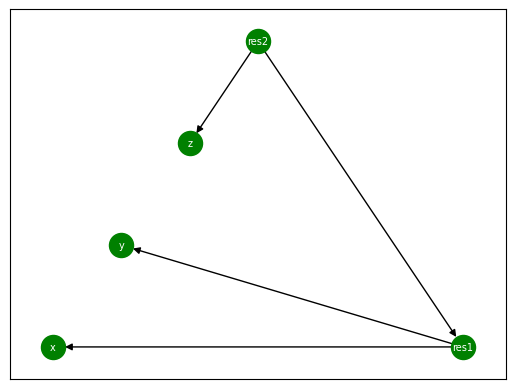

In [ ]:
input_graph = _create_graph(
    [('x', {'val': 1}), ('y', {'val': 2}), ('z', {'val': 3}), 'res1', 'res2'],
    [('res2','z'), ('res2','res1'), ('res1','x'), ('res1','y')]
)
_plot_graph(input_graph)

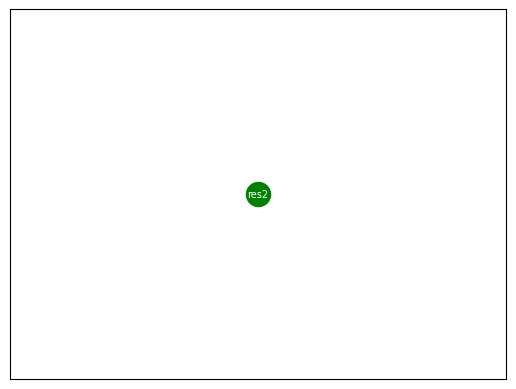

In [ ]:
matches = rewrite(input_graph,
        lhs='a->b[val]; a->c[val]', p='a', rhs='a[val={{val}}]',
        render_rhs={'val': lambda match: match['b']['val'] + match['c']['val']},
        is_recursive=True)
for match in matches:
    pass
_plot_graph(input_graph)

assert len(input_graph.nodes) == 1
assert input_graph.nodes['res2']
assert input_graph.nodes(data=True)['res2'] == {'val': 6}

### Integrating Spanner Workbench Micro-Passes
The following cells present a high-level approach for rewriting of the [AST micro-passes presented in the Spanner Workbench project](https://github.com/DeanLight/spanner_workbench/blob/master/src/rgxlog-interpreter/src/rgxlog/grammar/grammar.lark), as a proof that our library allows a simpler micro-pass writing method.

#### Description of Our Suggested Approach

We assume that the AST graph used in that project is a NetworkX graph (as our library requires). Each node in the graph has a *type* attribute which contains a string with the token-name that node has in the grammer, as well as all the attributes it had in the original, lark-produced AST.

In addition, each node has a *idx* attribute which denotes its position among the other children of its parent. That is, if a grammer rule defines ```PAR -> A B C```, then node A will have *idx* value of 0, B will have 1, etc. We use this attribute to handle the fact that in NetworkX graphs, children of some node are unordered.

Nodes which denote a constant (int, string, etc.) are constructed as regular nodes with a *val* attribute, containing that constant.

As you'll see in passes such as "Check Reserved Relation Names", our library allows a general method to do **assertions and type-checks**. Assume that some check validates that for each pattern LHS in the graph, a condition ```cond(...)``` holds. We will implement it as follows:
1. Match the pattern in the graph with LHS.
2. Use the ```condition``` parameter to filter the matches according to **the negation of ```cond```**. Thus, only matches for which the condition does **not** hold will remain.
3. Loop through the lists of remaining matches, and raise an exception for each one, as it fails the assertion. If none exist, then all matches passed the assertion, the check succeeded and no exception is raised.

Since we'll have a lot of checks here, where their specific implementation has nothing to do with our library, we will use a dummy assertion function that receives any number of parameters to visualize how such a check will look like:

In [ ]:
def _assertion(*args) -> bool:
    pass

In addition, we will calculate new values based on different parameters and Spanner Workbench classes (which we do not have in this module). Therefore, here's a dummy calculation function that receives any number of parameters and returns some calculated value (we'll use it only when the calculations depends on classes or functions of Spanner which we have no access to):

In [ ]:
def _calculation(*args) -> any:
    pass

Finally, most of the ```rewrite``` calls here do not require the lazy nature of the function, and actually need to exhaust the returned iterator. To make it easier, we suggest the following function:

In [ ]:
def _ex_rewrite(*args):
    matches = rewrite(*args)
    for _ in matches:
        pass

We will now go through the micro-passes and show (in high level) how we could rewrite them using our library.

#### Remove Tokens

In [ ]:
def _remove_tokens(ast):
    """
    a lark pass that should be used before the semantic checks
    transforms the lark tree by removing the redundant tokens
    note that we inherit from 'Transformer' in order to be able to visit token nodes.
    """
    _ex_rewrite(ast, lhs='a[type="INT", args]', p='a', rhs='a[val={{val}}]',
                render_rhs={'val': lambda match: int(match['a']['args'])})

    _ex_rewrite(ast, lhs='a[type="LOWER_CASE_NAME", args]', p='a', rhs='a[val={{val}}]',
                render_rhs={'val': lambda match: match['a']['args'].value})

    _ex_rewrite(ast, lhs='a[type="UPPER_CASE_NAME", args]', p='a', rhs='a[val={{val}}]',
                render_rhs={'val': lambda match: match['a']['args'].value})

    _ex_rewrite(ast, lhs='a[type="STRING", args]', p='a', rhs='a[val={{val}}]',
                render_rhs={'val': lambda match: match['a']['args'][1:-1]})

#### Check Reserved Relation Names

In [ ]:
def _check_reserved_relation_names(ast):
    """
    A lark tree semantic check.
    Checks if there are relations in the program with a name that starts with `RESERVED_RELATION_PREFIX`
    if such relations exist, throw an exception as this is a reserved name for rgxlog.
    """
    _ex_rewrite(ast, lhs='a[type="relation_name"]->rel_name[val]',
                condition=lambda match: _assertion(match['rel_name']['val']))

#### Fix Strings

In [ ]:
def _fix_strings(ast):
    """
    Fixes the strings in the lark tree.
    Removes the line overflow escapes from strings.
    """
    _ex_rewrite(ast, lhs='a[type="string"]->s[val]', rhs='a[type]->s[val={{fixed_val}}]',
                render_rhs={'fixed_val': lambda match: match['s']['val'].replace('\\\n', '')})

#### Convert Span Nodes To Span Instances

In [ ]:
def _convert_span_nodes_to_span_instances(ast):
    """
    Converts each span node in the ast to a span instance.
    This means that a span in the tree will be represented by a single value (a "DataTypes.Span" instance)
    instead of two integer nodes, making it easier to work with (as other data types are also represented by
    a single value).
    """
    _ex_rewrite(ast, lhs='s[type="span"]->start[idx=0]->start_val[val]; s->end[idx=1]->end_val[val]',
                p='s[type]', rhs='s[type]->span_child[val={{val}}]',
                render_rhs={'val': lambda match: (match['start_val']['val'], match['end_val']['val'])})

#### Convert Statements To Structured Nodes

This pass can be implemented partially using our current syntax. A full implenetation will be achievable only after implementing a depth-recursion method in the library's matcher, along with a predefined syntax that denotes such a pattern ("-+->").

In [ ]:
def _convert_statements_to_structured_nodes(ast):
    """
    converts each statement node in the tree to a structured node, making it easier to parse in future passes.
    a structured node is a class representation of a node in the abstract syntax tree.
    note that after using this pass, non statement nodes will no longer appear in the tree, so passes that
    should work on said nodes need to be used before this pass in the passes pipeline (e.g. FixString).
    """
    _ex_rewrite(ast, lhs="""ass[type="assignment"]->var_name_node[idx=0]; ass->value_node[idx=1];
                var_name_node->var_name[val]; value_node->value[val]""",
                p='ass[type]', rhs='ass[type]->ass_node[var_name={{var_name}}], value={{value}}, value_type={{value_type}}]',
                render_rhs={'var_name': lambda m: m['var_name']['val'], 'value': lambda m: m['value']['val'],
                                'var_name': lambda m: type(m['value']['val'])})

    _ex_rewrite(ast, lhs="""rass[type="read_assignment"]->var_name_node[idx=0]; rass->read_arg_node[idx=1];
                var_name_node->var_name[val]; read_arg_node->read_arg[val]""",
                p='rass[type]', rhs='rass[type]->rass_node[var_name={{var_name}}, read_arg={{read_arg}}, read_arg_type={{read_arg_type}}]',
                render_rhs={'var_name': lambda m: m['var_name']['val'], 'read_arg': lambda m: m['read_arg']['val'],
                                'read_arg_type': lambda m: type(m['read_arg']['val'])})
    
    # add_fact, remove_fact, query, relation_declaration and rule all use list tokens, that define a recursive list of unknown length.
    # While such pattern cannot be identified with our current syntax, it WILL be possible when implementing a depth-recursive,
    # a concept which can be assigned with the syntax -+->.

#### Check Defined Referenced Variables

Assumes the existence of a symbol table, in addition to the AST.

In [ ]:
def _check_defined_referenced_variables(ast, sym_tab):
    """
    A lark tree semantic check.
    checks whether each variable reference refers to a defined variable.
    """
    _ex_rewrite(ast, lhs='_[type="assignment"]->ass_node[value_type, value]',
               condition=lambda match: _assertion(match['ass_node']['value_type'], match['ass_node']['value']))

    _ex_rewrite(ast, lhs='_[type="read_assignment"]->rass_node[read_arg_type, read_arg]',
                condition=lambda match: _assertion(match['rass_node']['read_arg_type'], match['rass_node']['read_arg']))

    _ex_rewrite(ast, lhs='_[type="add_fact]->afact_node[term_list, type_list]',
                condition=lambda match: _assertion(match['afact_node']['term_list'], match['afact_node']['type_list'], sym_tab))
    
    _ex_rewrite(ast, lhs='_[type="remove_fact]->rfact_node[term_list, type_list]',
               condition=lambda match: _assertion(match['rfact_node']['term_list'], match['rfact_node']['type_list'], sym_tab))

    _ex_rewrite(ast, lhs='_[type="query"]->query_node[term_list, type_list]',
                condition=lambda match: _assertion(match['query_node']['term_list'], match['query_node']['type_list'], sym_tab))

    _ex_rewrite(ast, lhs='_[type="rule"]->rule_node[body_relation_list, body_relation_type_list]',
                condition=lambda match: _assertion(match['rule_node']['body_relation_list'], match['rule_node']['type_list'], sym_tab))

#### Check Referenced Relations Existence And Arity

Assumes the existence of a symbol table, in addition to the AST.

In [ ]:
def _check_referenced_relations_existence_and_arity(ast, sym_tab):
    """
    A lark tree semantic check.
    Checks whether each normal relation (that is not an ie relation) reference refers to a defined relation.
    Also checks if the relation reference uses the correct arity.
    """
    _ex_rewrite(ast, lhs='_[type="query"]->query_node[relation_name, term_list]',
                condition=lambda match: _assertion(match['query_node']['relation_name'], match['query_node']['term_list'], sym_tab))
    
    _ex_rewrite(ast, lhs='_[type="add_fact"]->afact_node[relation_name, term_list]',
                condition=lambda match: _assertion(match['afact_node']['relation_name'], match['afact_node']['term_list'], sym_tab))

    _ex_rewrite(ast, lhs='_[type="remove_fact"]->rfact_node[relation_name, term_list]',
                condition=lambda match: _assertion(match['rfact_node']['relation_name'], match['rfact_node']['term_list'], sym_tab))

    _ex_rewrite(ast, lhs='_[type="rule"]->rule_node[body_relation_list, body_relation_type_list]',
                condition=lambda match: _assertion(match['rule_node']['body_relation_list'], match['rule_node']['type_list'], sym_tab))

#### Check Referenced IE Relations Existence And Arity

Assumes the existence of a symbol table, in addition to the AST.

In [ ]:
def _check_referenced_ie_relations_existence_and_arity(ast, sym_tab):
    """
    A lark tree semantic check.
    Checks whether each ie relation reference refers to a defined ie function.
    Also checks if the correct input arity and output arity for the ie function were used.

    currently, an ie relation can only be found in a rule's body, so this is the only place where this
    check will be performed.
    """
    _ex_rewrite(ast, lhs='_[type="rule"]->rule_node[body_relation_list, body_relation_type_list]',
                condition=lambda match: _assertion(match['rule_node']['body_relation_list'], match['rule_node']['type_list'], sym_tab))

#### Check Rule Safety

In [ ]:
def _check_rule_safety(ast):
    """
    A lark tree semantic check.
    checks whether the rules in the programs are safe.
    """
    _ex_rewrite(ast, lhs='_[type="rule"]->rule_node[head_relation, body_relation_list, body_relation_type_list]',
                condition=lambda match: _assertion(match['rule_node']['head_relation'], match['rule_node']['body_relation_list'], match['rule_node']['type_list']))

#### Type Check Assignments

Assumes the existence of a symbol table, in addition to the AST.

In [ ]:
def _type_check_assignments(ast, sym_tab):
    """
    a lark semantic check
    performs type checking for assignments
    in the current version of lark, this type checking is only required for read assignments.
    """
    _ex_rewrite(ast, lhs='_[type="assignment"]->ass_node[read_arg_type, read_arg]',
                condition=lambda match: _assertion(match['ass_node']['read_arg_type'], match['ass_node']['read_arg'], sym_tab))

#### Type Check Relations

Assumes the existence of a symbol table, in addition to the AST.

In [ ]:
def _type_check_relations(ast, sym_tab):
    """
    A lark tree semantic check.
    This pass makes the following assumptions and might not work correctly if they are not met
    1. that relations and ie relations references and correct arity were checked.
    2. variable references were checked.
    3. it only gets a single statement as an input.

    this pass performs the following checks:
    1. checks if relation references are properly typed.
    2. checks if ie relations are properly typed.
    3. checks if free variables in rules do have conflicting types.
    """
    _ex_rewrite(ast, lhs='_[type="add_fact"]->afact_node[relation_name, term_list, type_list]',
                condition=lambda match: _assertion(match['afact_node']['relation_name'], match['afact_node']['term_list'], 
                                               match['afact_node']['type_list'], sym_tab))
    
    _ex_rewrite(ast, lhs='_[type="remove_fact"]->rfact_node[relation_name, term_list, type_list]',
                condition=lambda match: _assertion(match['rfact_node']['relation_name'], match['rfact_node']['term_list'], 
                                               match['rfact_node']['type_list'], sym_tab))

    _ex_rewrite(ast, lhs='_[type="query"]->query_node[relation_name, term_list, type_list]',
                condition=lambda match: _assertion(match['query_node']['relation_name'], match['query_node']['term_list'], 
                                               match['query_node']['type_list'], sym_tab))

    _ex_rewrite(ast, lhs='_[type="rule"]->rule_node[body_relation_list, body_relation_type_list]',
                condition=lambda match: _assertion(match['rule_node']['body_relation_list'], match['rule_node']['type_list'], sym_tab))

#### Save Declared Relations Schemas

Assumes the existence of a symbol table, in addition to the AST.

In [ ]:
def _save_declared_relations_schemas(ast, sym_tab):
    """
    this pass writes the relation schemas that it finds in relation declarations and rule heads* to the
    symbol table.
    * note that a rule is a relation declaration of the rule head relation and a definition of its contents

    this pass assumes that type checking was already performed on its input.
    """
    matches = rewrite(ast, lhs='_[type="relation_declaration"]->reldec_node[relation_name, type_list]')
    for match in matches:
        # Does some imperative side-effect that adds to the sym_tab, based on the match's relation_name, type_list
        pass

    matches = rewrite(ast, lhs='_[type="rule"]->rule_node[body_relation_list, body_relation_type_list]',
                      condition=lambda match: _assertion(match['rule_node']['body_relation_list'], match['rule_node']['body_relation_type_list'], sym_tab))
    for match in matches:
        # Does some imperative side-effect that adds each relation in the rule to the sym_tab
        pass

#### Resolve Variables References

Assumes the existence of a symbol table, in addition to the AST.

In [ ]:
def _resolve_variables_references(ast, sym_tab):
    """
    a lark execution pass
    this pass replaces variable references with their literal values.
    also replaces DataTypes.var_name types with the real type of the variable.
    """
    _ex_rewrite(ast, lhs='ass[type="assignment"]->ass_node[value_type, value]',
                condition=lambda match: _assertion(match['ass_node']['value_type']),
                rhs='ass[type]->ass_node[value_type={{value_type}}, value={{value}}]',
                render_rhs={
                    'value_type': lambda match: _calculation(match['ass_node']['value'], sym_tab),
                    'value': lambda match: _calculation(match['ass_node']['value'], sym_tab)})
    
    _ex_rewrite(ast, lhs='rass[type="read_assignment"]->rass_node[read_arg_type, read_arg]',
            condition=lambda match: _assertion(match['rass_node']['read_arg_type']),
            rhs='ass[type]->rass_node[read_arg_type={{read_arg_type}}, read_arg={{read_arg}}]',
            render_rhs={
                'read_arg_type': lambda match: _calculation(match['rass_node']['read_arg'], sym_tab),
                'read_arg': lambda match: _calculation(match['rass_node']['read_arg'], sym_tab)})

    _ex_rewrite(ast, lhs='query[type="query"]->query_node[term_list, type_list]',
                rhs='query[type]->query_node[term_list={{term_list}}, type_list={{type_list}}]',
                render_rhs={
                    'term_list': lambda match: _calculation(match['query_node']['term_list'], match['query_node']['type_list'], sym_tab),
                    'type_list': lambda match: _calculation(match['query_node']['term_list'], match['query_node']['type_list'], sym_tab)
                })
    
    _ex_rewrite(ast, lhs='afact[type="add_fact"]->afact_node[term_list, type_list]',
                rhs='afact[type]->afact_node[term_list={{term_list}}, type_list={{type_list}}]',
                render_rhs={
                    'term_list': lambda match: _calculation(match['afact_node']['term_list'], match['afact_node']['type_list'], sym_tab),
                    'type_list': lambda match: _calculation(match['afact_node']['term_list'], match['afact_node']['type_list'], sym_tab)
                })

    _ex_rewrite(ast, lhs='rfact[type="remove_fact"]->rfact_node[term_list, type_list]',
                rhs='rfact[type]->rfact_node[term_list={{term_list}}, type_list={{type_list}}]',
                render_rhs={
                    'term_list': lambda match: _calculation(match['rfact_node']['term_list'], match['rfact_node']['type_list'], sym_tab),
                    'type_list': lambda match: _calculation(match['rfact_node']['term_list'], match['rfact_node']['type_list'], sym_tab)
                })
    
    _ex_rewrite(ast, lhs='rule[type="rule"]->rule_node[body_relation_list, body_relation_type_list]',
                condition=lambda match: _assertion(match['rule_node']['body_relation_list'], match['rule_node']['body_relation_type_list']),
                rhs='rule[type="rule"]->rule_node[body_relation_list={{brl}}, body_relation_type_list={{brtl}}]',
                render_rhs={
                    'brl': lambda match: _calculation(match['rule_node']['body_relation_list'], match['rule_node']['body_relation_type_list'], sym_tab),
                    'brtl': lambda match: _calculation(match['rule_node']['body_relation_list'], match['rule_node']['body_relation_type_list'], sym_tab)
                })

#### Execute Assignments

Assumes the existence of a symbol table, in addition to the AST.

In [ ]:
def _execute_assignments(ast, sym_tab):
    """
    a lark execution pass
    executes assignments by saving variables' values and types in the symbol table
    should be used only after variable references are resolved, meaning the assigned values and read() arguments
    are guaranteed to be literals.
    """
    matches = rewrite(ast, lhs='ass[type="assignment"]->ass_node[var_name, value, value_type]')
    for match in matches:
        # Imperative side-effect that uses each match's var_name, value, value_type and updates the sym_tab (executes assignment)
        pass

    matches = rewrite(ast, lhs='rass[type="read_assignment"]->rass_node[read_arg, var_name]')
    for match in matches:
        # Imperative side-effect that uses each match's read_arg, var_name and updates the sym_tab (executes assignment)
        pass

#### Add Statements To Netx Parse Graph

Assumes the existence of a parse graph, in addition to the AST.

In [ ]:
def _add_statements_to_netx_parse_graph(ast, parse_graph):
    """
    A lark execution pass.
    This pass adds each statement in the input parse tree to the parse graph.
    This pass is made to work with execution.naive_execution as the execution function and
    term_graph.NetxStateGraph as the parse graph.

    Each statement in the parse graph will be a child of the parse graph's root.

    Each statement in the parse graph will have a type attribute that contains the statement's name in the
    rgxlog grammar.

    Some nodes in the parse graph will contain a value attribute that would contain a relation that describes
    that statement.
    e.g. a add_fact node would have a value which is a structured_nodes.AddFact instance
    (which inherits from structured_nodes.Relation) that describes the fact that will be added.

    Some statements are more complex and will be described by more than a single node, e.g. a rule node.
    The reason for this is that we want a single netx node to not contain more than one Relation
    (or IERelation) instance. This will make the parse graph a "graph of relation nodes", allowing
     for flexibility for optimization in the future.
    """
    matches = rewrite(ast, lhs='_[type="add_fact"]->afact_node')
    for match in matches:
        # Imperative side-effect that adds a new node to parse_graph, based on afact_node's attrs
        pass

    matches = rewrite(ast, lhs='_[type="remove_fact"]->rfact_node')
    for match in matches:
        # Imperative side-effect that adds a new node to parse_graph, based on rfact_node's attrs
        pass

    matches = rewrite(ast, lhs='_[type="query"]->query_node')
    for match in matches:
        # Imperative side-effect that adds a new node to parse_graph, based on query_node's attrs
        pass

    matches = rewrite(ast, lhs='_[type="relation_declaration"]->reldec_node')
    for match in matches:
        # Imperative side-effect that adds a new node to parse_graph, based on reldec_node's attrs
        pass

    matches = rewrite(ast, lhs='_[type="rule"]->rule_node')
    for match in matches:
        # Imperative side-effect that adds a new node to parse_graph, based on rule_node's attrs
        pass